# Test our algorithm on rNLTT stars with Hipparchos parallaxes

In [1]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import parallax
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import pickle

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### First, read in data from catalogs

In [2]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
t = t_full[ids_good]

In [3]:
print t.colnames

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'HIP', 'V', 'B', 'R', 'J', 'H', 'K']


In [4]:
# Read in sample from Tycho-2 table
filename = ('../data/hipparchos/hip2.dat')
readme = ('../data/hipparchos/ReadMe')
hip = Table.read(filename, format='cds', guess=False, readme=readme)

In [5]:
print hip.colnames

['HIP', 'Sn', 'So', 'Nc', 'RArad', 'DErad', 'Plx', 'pmRA', 'pmDE', 'e_RArad', 'e_DErad', 'e_Plx', 'e_pmRA', 'e_pmDE', 'Ntr', 'F2', 'F1', 'var', 'ic', 'Hpmag', 'e_Hpmag', 'sHp', 'VA', 'B-V', 'e_B-V', 'V-I']


In [6]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
CG_pairs = CG_pairs[0:-1]  # Because the last line is blank
print CG_pairs.colnames

['NLTT-A', 'NLTT-B', 'RAdegA', 'DEdegA', 'RAdegB', 'DEdegB', 'pmRA-A', 'pmDE-A', 'pmRA-B', 'pmDE-B', 'VmagA', '(V-J)A', 'VmagB', '(V-J)B', 'SC-A', 'SC-B', 'CCode', 'Delpm', 'DelSep', 'PosAng', 'Bin', 'Allen']


In [7]:
idx = np.array([], dtype='i8')
for i in np.arange(len(CG_pairs)):
    id1 = np.where(CG_pairs['NLTT-A'][i] == t_full['NLTT'])[0]
    id2 = np.where(CG_pairs['NLTT-B'][i] == t_full['NLTT'])[0]
    
    if len(id1) != 0 and len(id2) != 0 and id1[0] != id2[0] and CG_pairs['CCode'][i]<4:
        if t_full['HIP'][id1[0]] != t_full['HIP'][id2[0]] and t_full['HIP'][id1[0]] != 0 and t_full['HIP'][id2[0]] != 0:
            idx = np.append(idx, i)

CG_pairs_hip = CG_pairs[idx]

print "CG04 pairs with independent Hipparchos IDs (and CCode 1-3):", len(CG_pairs_hip)

CG04 pairs with independent Hipparchos IDs (and CCode 1-3): 44


### Play with Hipparchos data

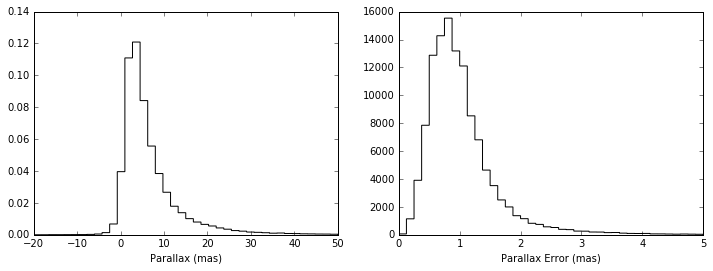

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(hip['Plx'], histtype='step', color='k', bins=40, range=(-20, 50), normed=True)
ax[1].hist(hip['e_Plx'], histtype='step', color='k', bins=40, range=(0, 5))

ax[0].set_xlabel('Parallax (mas)')
ax[1].set_xlabel('Parallax Error (mas)')

plt.show()

### Now, let's select all rNLTT stars with Hipparchos numbers

In [8]:
t_hip_tmp = t_full[np.where(t_full['HIP']!=0)[0]]

# Only non-repeating entries
vals, indices = np.unique(t_hip_tmp['NLTT'], return_index=True)
t_hip = t_hip_tmp[indices]


dtype = [('ID','i8'),('NLTT','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('B','f8'),('V','f8'), \
         ('plx','f8'),('plx_err','f8')]

t = np.zeros(len(t_hip), dtype=dtype)
t['ID'] = t_hip['HIP']
t['NLTT'] = t_hip['NLTT']
t['ra'] = t_hip['ra']
t['dec'] = t_hip['dec']
t['mu_ra'] = t_hip['mu_ra']
t['mu_dec'] = t_hip['mu_dec']
t['mu_ra_err'] = t_hip['mu_ra_err']
t['mu_dec_err'] = t_hip['mu_dec_err']
t['B'] = t_hip['B']
t['V'] = t_hip['V']

# Get parallaxes, by first finding indices matching two catalogs
idx = np.zeros(len(t_hip), dtype='i8')
for i in np.arange(len(t_hip)):
    idx[i] =int(np.where(t_hip[i]['HIP'] == hip['HIP'])[0][0])
    
t['plx'] = hip['Plx'][idx]
t['plx_err'] = hip['e_Plx'][idx]

In [9]:
print len(t_full), len(t)

36085 8288


In [ ]:
# Run search for wide binaries

p_out = P_posterior.match_binaries(t, plx_kde_bandwidth=1.0, pos_kde_bandwidth=10.0, mu_kde_bandwidth=30.0)

Generating binaries...
Done generating binaries
Calculating normalization for random alignment prior...
Done setting prior.
We are testing 8288 stars...
13 16 428 473 328.24266543 869.799972 -150.700003 878.700018 -153.899997 88.88 1.42 88.44 1.56 3.27460746028e-16 7.02024929924e-06 0.999999910876
13

In [11]:
print parallax.plx_kde.bandwidth
print P_random.pos_kde.bandwidth
print P_random.mu_kde.bandwidth

1.0
10.0
30.0


In [21]:
pickle.dump(p_out, open("../data/rNLTT/rNLTT_hipparchos.p", "wb"))

In [30]:
f = open('rNLTT_hip_coor.txt', 'wb')

for p in p_out:
    if p['P_posterior'] > 0.5:
        f.write(str(t['ra'][p['i_1']]) + str(t['dec'][p['i_1']]) + '\n')
        f.write(str(t['ra'][p['i_2']]) + str(t['dec'][p['i_2']]) + '\n')

f.close()


In [10]:
p_out = pickle.load(open("../data/rNLTT/rNLTT_hipparchos.p", "rb"))

In [22]:
# Save only independent matches to p_ind
idx = np.where(p_out['ID_1'] != p_out['ID_2'])
p_tmp = p_out[idx]
tmp_NLTT, idx_NLTT = np.unique(p_tmp['ID_1'], return_index=True)
p_ind = p_tmp[idx_NLTT]

print len(p_ind)

114


### Now, let's look at the 118 independent matches

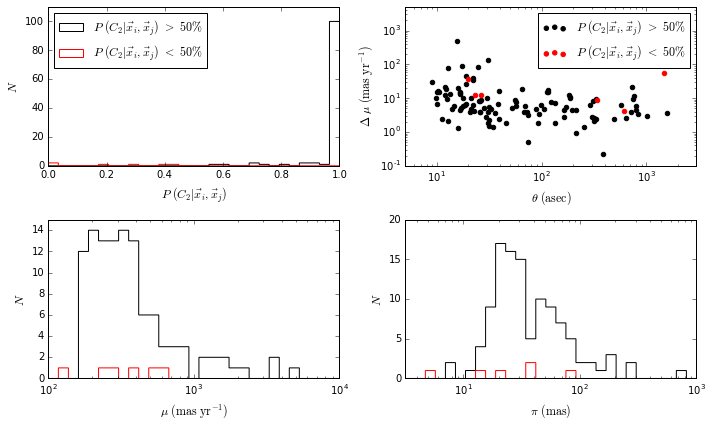

In [13]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

# P_posterior
bins = np.linspace(0.0, 1.0, 30)
ax[0,0].hist(p_ind['P_posterior'][p_ind['P_posterior']>0.5], histtype='step', bins=bins, color='k', label=r'$P\ (C_2|\vec{x}_i, \vec{x}_j)\ >\ 50\%$')
ax[0,0].hist(p_ind['P_posterior'][p_ind['P_posterior']<0.5], histtype='step', bins=bins, color='r', label=r'$P\ (C_2|\vec{x}_i, \vec{x}_j)\ <\ 50\%$')
ax[0,0].set_ylim(0,110)
ax[0,0].set_xlabel(r'$P\ (C_2|\vec{x}_i, \vec{x}_j)$', fontsize=12)
ax[0,0].set_ylabel(r'$N$', fontsize=12)
ax[0,0].legend(loc=2)

# Theta vs. Delta Mu
delta_mu_ra = p_ind['mu_ra_1'] - p_ind['mu_ra_2']
delta_mu_dec = p_ind['mu_dec_1'] - p_ind['mu_dec_2']
delta_mu = np.sqrt(delta_mu_ra**2 + delta_mu_dec**2)
ax[0,1].scatter(p_ind['theta'][p_ind['P_posterior']>0.5]*3600.0, delta_mu[p_ind['P_posterior']>0.5], color='k', label=r'$P\ (C_2|\vec{x}_i, \vec{x}_j)\ >\ 50\%$')
ax[0,1].scatter(p_ind['theta'][p_ind['P_posterior']<0.5]*3600.0, delta_mu[p_ind['P_posterior']<0.5], color='r', label=r'$P\ (C_2|\vec{x}_i, \vec{x}_j)\ <\ 50\%$')
ax[0,1].set_xlim(5.0, 3000.0)
ax[0,1].set_ylim(0.1, 5000.0)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].legend()
ax[0,1].set_xlabel(r'$\theta\ ({\rm asec})$', fontsize=12)
ax[0,1].set_ylabel(r'$\Delta\ \mu\ ({\rm mas\ yr}^{-1})$', fontsize=12)


# Mu
mu_1 = np.sqrt(p_ind['mu_ra_1']**2 + p_ind['mu_dec_1']**2)
mu_2 = np.sqrt(p_ind['mu_ra_2']**2 + p_ind['mu_dec_2']**2)
bins = 10**np.linspace(2.0, 4.0, 30)
ax[1,0].hist(mu_1[p_ind['P_posterior']>0.5], histtype='step', bins=bins, color='k')
ax[1,0].hist(mu_1[p_ind['P_posterior']<0.5], histtype='step', bins=bins, color='r')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel(r"$\mu\ ({\rm mas\ yr}^{-1})$", fontsize=12)
ax[1,0].set_ylim(0.0, 15.0)
ax[1,0].set_ylabel(r'$N$', fontsize=12)


# Parallax
bins = 10**np.linspace(0.5, 3.0, 30)
ax[1,1].hist(p_ind['plx_1'][p_ind['P_posterior']>0.5], histtype='step', bins=bins, color='k')
ax[1,1].hist(p_ind['plx_1'][p_ind['P_posterior']<0.5], histtype='step', bins=bins, color='r')
ax[1,1].set_xscale('log')
ax[1,1].set_xlim(10**0.5, 10**3.0)
ax[1,1].set_ylim(0.0, 20.0)
ax[1,1].set_xlabel(r"$\pi\ ({\rm mas})$", fontsize=12)
ax[1,1].set_ylabel(r'$N$', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/rNLTT_hipparchos.pdf')
#plt.show()

### Test the parallax prior, bandwidth and position, mu priors

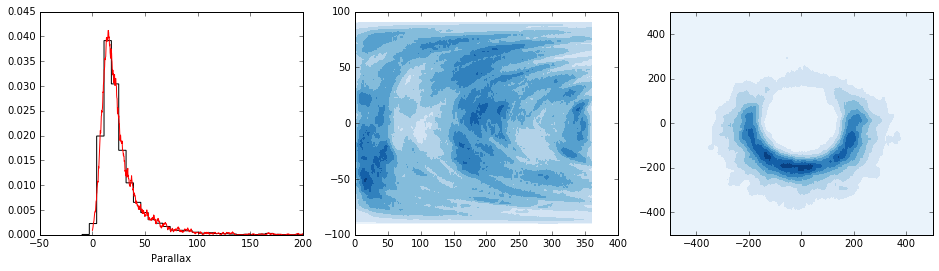

In [15]:
parallax.plx_kde = None
parallax.set_plx_kde(t, bandwidth=1.0)
P_random.mu_kde = None
P_random.pos_kde = None
#c.kde_subset = False



fig, ax = plt.subplots(1, 3, figsize=(16, 4))


ax[0].hist(t['plx'], color='k', histtype='step', bins=30, range=(-10, 200), normed=True)

ran_x = np.linspace(0, 200, 1000)
ran_y = parallax.get_plx_prior(ran_x)
ax[0].plot(ran_x, ran_y, color='r')
ax[0].set_xlabel('Parallax')


tmp_x = np.linspace(0, 360.0, 1000)
tmp_y = np.linspace(-90.0, 90.0, 100)
X, Y = np.meshgrid(tmp_x, tmp_y)
Z = P_random.get_sigma_pos(X.flatten(), Y.flatten(), catalog=t, bandwidth=10.0, method='sklearn_kde')
ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', extend='max')
#ax[1].scatter(t['ra'], t['dec'], marker='.', alpha=0.1, color='k')


tmp_x = np.linspace(-1000, 1000.0, 1000)
tmp_y = np.linspace(-1000.0, 1000.0, 100)
X, Y = np.meshgrid(tmp_x, tmp_y)
Z = P_random.get_sigma_mu(X.flatten(), Y.flatten(), catalog=t, method='sklearn_kde', bandwidth=30.0)
ax[2].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', extend='max')
#ax[2].scatter(t['mu_ra'], t['mu_dec'], marker='.', color='k', alpha=0.01)
ax[2].set_xlim(-500, 500)
ax[2].set_ylim(-500, 500)


plt.show()

### Calculate probabilities of Chaname & Gould pairs

In [74]:
P_binary.generate_binary_set(num_sys=10000)


#print CG_pairs_hip.dtype

# Use KDEs with bandwidths calibrated to this data set
parallax.plx_kde = None
parallax.set_plx_kde(t, bandwidth=1.0)
P_random.mu_kde = None
P_random.pos_kde = None
test_val = np.ones(1, dtype='f8')
sigma_pos = P_random.get_sigma_pos(test_val, test_val, catalog=t, bandwidth=10.0, method='sklearn_kde')
sigma_mu = P_random.get_sigma_mu(test_val, test_val, catalog=t, bandwidth=30.0, method='sklearn_kde')



dtype = [('i_1','i4'),('i_2','i4'),('ID_1','i4'),('ID_2','i4'),('P_random','f8'),('P_binary','f8'), \
         ('P_posterior','f8'),('theta','f8'), ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_2','f8'), \
         ('mu_dec_2','f8'), ('plx_1','f8'), ('plx_2','f8')]

CG_pairs_hip_all = np.zeros(len(CG_pairs_hip), dtype=dtype)


for i in np.arange(len(CG_pairs_hip)):
    
    id1 = np.where(CG_pairs_hip['NLTT-A'][i] == t['NLTT'])[0]
    id2 = np.where(CG_pairs_hip['NLTT-B'][i] == t['NLTT'])[0]

    star1 = t['ra'][id1][0], t['dec'][id1][0], t['mu_ra'][id1][0], t['mu_dec'][id1][0], t['mu_ra_err'][id1][0], t['mu_dec_err'][id1][0]
    star2 = t['ra'][id2][0], t['dec'][id2][0], t['mu_ra'][id2][0], t['mu_dec'][id2][0], t['mu_ra_err'][id2][0], t['mu_dec_err'][id2][0]

    print star1[0], star1[1], star2[0], star2[1]

    pos_density = P_random.get_sigma_pos(t['ra'][id1], t['dec'][id1], catalog=t, method='sklearn_kde')
    pm_density, tmp = P_random.get_sigma_mu(t['mu_ra'][id1]*np.ones(2), t['mu_dec'][id1]*np.ones(2), catalog=t, method='sklearn_kde')

    prob_posterior, prob_random, prob_binary = P_posterior.calc_P_posterior(star1, star2, pos_density, pm_density, id1, id2, t)

    theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2])
    
    prob_posterior1 = prob_posterior
    
    
    # Check, by going backwards
    star1 = t['ra'][id2], t['dec'][id2], t['mu_ra'][id2], t['mu_dec'][id2], t['mu_ra_err'][id2], t['mu_dec_err'][id2]
    star2 = t['ra'][id1], t['dec'][id1], t['mu_ra'][id1], t['mu_dec'][id1], t['mu_ra_err'][id1], t['mu_dec_err'][id1]

    prob_posterior, prob_random, prob_binary = P_posterior.calc_P_posterior(star1, star2, pos_density, pm_density, id1, id2, t)

    prob_posterior2 = prob_posterior

    
    print i, t['ID'][id1], t['ID'][id2], prob_posterior1, prob_posterior2

    
    # Use first version
    prob_posterior = prob_posterior1
    
    CG_pairs_hip_all[i] = id1, id2, t['ID'][id1], t['ID'][id2], prob_random, prob_binary, prob_posterior, theta, \
                   t['mu_ra'][id1], t['mu_dec'][id1], t['mu_ra'][id2], t['mu_dec'][id2], t['plx'][id1], \
                   t['plx'][id2]

25.9131889 28.0560017 25.9183064 28.0527649
0 [8067] [8069] 0.998217341181 [ 0.99731435]
32.0996437 28.3107796 32.0995445 28.3050423
1 [9971] [9972] 0.999999930226 [ 0.99999993]
33.1943245 -2.39636111 33.1980896 -2.39362693
2 [10303] [10305] 0.999998565883 [ 0.99999871]
35.8212433 15.4170113 35.8311195 15.4185667
3 [11134] [11137] 0.999999977167 [ 0.99999998]
47.1021576 -24.1732311 47.1069527 -24.1675949
4 [14589] [14593] 0.9999451058 [ 0.99994731]
50.0122604 -28.7838326 50.0149078 -28.8540726
5 [15526] [15527] 0.999999198359 [ 0.99999909]
54.2351723 -28.1376457 54.2420959 -28.1314602
6 [16858] [16860] 0.999998969064 [ 0.9999988]
55.9385414 16.6672592 55.9690247 16.6720238
7 [17405] [17414] 0.999999794888 [ 0.9999998]
77.5036163 27.6431885 77.5161285 27.556509
8 [24035] [24046] 0.999987700463 [ 0.99998682]
85.3347321 53.4810562 85.3780441 53.4897995
9 [26779] [26801] 0.999999985328 [ 0.99999998]
107.001007 15.528595 107.049927 15.5208502
10 [34407] [34426] 0.999925739223 [ 0.99992227]


In [77]:
print parallax.plx_kde.bandwidth
print P_random.pos_kde.bandwidth
print P_random.mu_kde.bandwidth
print len(CG_pairs_hip)
print len(p_ind)

1.0
10.0
30.0
44
114


In [47]:
for i in np.arange(len(CG_pairs_hip_all)):
    plx_err = np.sqrt(t['plx_err'][CG_pairs_hip_all[i][0]]**2 + t['plx_err'][CG_pairs_hip_all[i][1]]**2)
    plx_diff = np.abs(t['plx'][CG_pairs_hip_all[i][0]] - t['plx'][CG_pairs_hip_all[i][1]])
    NLTT_A = t['NLTT'][CG_pairs_hip_all[i][0]]
    NLTT_B = t['NLTT'][CG_pairs_hip_all[i][1]]
    print NLTT_A, NLTT_B, t['plx'][CG_pairs_hip_all[i][0]], t['plx'][CG_pairs_hip_all[i][1]], plx_err, plx_diff, plx_diff / plx_err

5738 5740 21.11 -5.63 14.4261464016 26.74 1.85357885991
7087 7088 17.82 10.82 7.05207061791 7.0 0.992616265388
7321 7323 20.89 25.19 7.52331044155 4.3 0.571556900836
7843 7845 17.51 17.01 2.12708721025 0.5 0.235063234639
10007 10008 48.29 31.43 6.57231313922 16.86 2.56530686272
10635 10636 28.27 28.15 1.24531120608 0.12 0.0963614552039
11421 11423 22.66 21.15 4.94726186895 1.51 0.305219339505
11688 11693 59.92 56.46 3.06569731056 3.46 1.12861761925
14572 14576 25.21 24.98 1.43951380681 0.23 0.159776168114
15439 15446 81.45 80.4 1.77417586501 1.05 0.591824080524
17443 17446 21.39 21.8 1.17686022959 0.41 0.348384616703
17998 17999 83.46 84.26 5.33548498264 0.8 0.149939509267
18346 18347 7.75 -8.85 6.69077723437 16.6 2.48102715402
19428 19431 25.23 26.49 5.23473017452 1.26 0.24070008539
21249 21251 172.08 156.45 10.6504694732 15.63 1.46754094167
22121 22125 12.17 17.15 3.31126863906 4.98 1.50395529413
22340 22350 81.37 88.07 2.99015049788 6.7 2.24068989328
23007 23008 23.94 23.85 1.303840

### Compare with Pairs in the Chaname & Gould (2004) catalog

In [70]:
idx_match = np.array([], dtype='i8')
idx_new = np.array([], dtype='i8')
idx_bad = np.array([], dtype='i8')

counter = 0
for i in np.arange(len(CG_pairs_hip_all)):
    
    NLTT_A = t['NLTT'][CG_pairs_hip_all[i][0]]
    NLTT_B = t['NLTT'][CG_pairs_hip_all[i][1]]
    
    id1 = np.where(NLTT_A == t['NLTT'][p_ind['i_1']])[0]
    id2 = np.where(NLTT_B == t['NLTT'][p_ind['i_2']])[0]

    if len(id1) != 0 and len(id2) != 0 and id1 == id2:
        idx_match = np.append(idx_match, i)
    else:
        idx_bad = np.append(idx_bad, i)

for i in idx_bad:
    t_id1, t_id2 = CG_pairs_hip_all[i][0], CG_pairs_hip_all[i][1]
    print i, t['plx'][t_id1], t['plx'][t_id2], CG_pairs_hip_all[i][7]

    # Not parallax difference
    # Not angle distance
    

# for i in np.arange(len(p_ind)):
    
#     id1 = np.where(CG_pairs_hip['NLTT-A'] == t['NLTT'][p_ind['i_1'][i]])[0]
#     id2 = np.where(CG_pairs_hip['NLTT-B'] == t['NLTT'][p_ind['i_2'][i]])[0]
    
#     if len(id1) != 0 and len(id2) != 0 and id1 == id2 and p_ind['P_posterior'][i]>0.1:
# #    if len(id1) != 0 and len(id2) != 0 and id1 == id2:
#         idx_match = np.append(idx_match, i)
#     elif p_ind['P_posterior'][i]>0.1:
#         idx_new = np.append(idx_new, i)
#     else:
#         idx_bad = np.append(idx_bad, i)
        

# for i in idx_match:
#     p = p_ind[i]
#     print t['NLTT'][p['i_1']], t['NLTT'][p['i_2']]
        
print "Matched Pairs:", len(idx_match)
# print "New Pairs:", len(idx_new)
print "Rejected Pairs:", len(idx_bad)

1 17.82 10.82 0.00573796471032
2 20.89 25.19 0.00465047989266
4 48.29 31.43 0.00713476976424
11 83.46 84.26 0.0106174938725
13 25.23 26.49 0.00810488887847
29 45.77 46.48 0.00873362361742
Matched Pairs: 38
Rejected Pairs: 6


In [13]:


for i in np.arange(len(CG_pairs_hip)):
    id1 = np.where(CG_pairs_hip_all['ID_1'][i] == t['ID'][p_ind['i_1'][idx_match]])[0]
    
    if len(id1) == 0:
        print CG_pairs_hip_all['ID_1'][i]
        print t[t['ID'] == CG_pairs_hip_all['ID_1'][i]]
        print t[t['ID'] == CG_pairs_hip_all['ID_2'][i]]
        print
        

NameError: name 'CG_pairs_hip_all' is not defined

### Compare probabilities for matched pairs from both methods

In [33]:
print len(np.where(CG_pairs_hip_all['P_posterior']>0.5)[0])
print len(CG_pairs_hip_all)

for i in np.arange(len(CG_pairs_hip_all)):

    # ID_1 and ID_2 are Hipparchos IDs
    id1 = np.where(CG_pairs_hip_all['ID_1'][i] == p_ind['ID_1'][idx_match])[0]
    id2 = np.where(CG_pairs_hip_all['ID_2'][i] == p_ind['ID_2'][idx_match])[0]

    if len(id1) != 0 and len(id2) != 0 and id1 == id2:
 
        print CG_pairs_hip_all['P_posterior'][i], p_ind['P_posterior'][idx_match][id1]

    else:
        print CG_pairs_hip_all['ID_1'][i], CG_pairs_hip_all['ID_2'][i]
#         plx_err = np.sqrt(t['plx_err'][CG_pairs_hip_all['i_1'][i]]**2 + t['plx_err'][CG_pairs_hip_all['i_2'][i]]**2)
#         print t['NLTT'][CG_pairs_hip_all['i_1'][i]], t['NLTT'][CG_pairs_hip_all['i_2'][i]], CG_pairs_hip_all['P_posterior'][i], \
#             np.abs(t['plx'][CG_pairs_hip_all['i_1'][i]]-t['plx'][CG_pairs_hip_all['i_2'][i]]), plx_err

43
44
0.563460016558 [ 0.60684105]
0.999969778704 [ 0.99997009]
0.999502536351 [ 0.9996286]
0.999997766336 [ 0.99999759]
0.995126495754 [ 0.99750071]
0.999642506648 [ 0.99967706]
0.999937421259 [ 0.9999414]
0.999967097541 [ 0.99997208]
0.999025698966 [ 0.99918378]
0.99999350294 [ 0.9999937]
0.984960724157 [ 0.9839567]
0.999991685027 [ 0.99998964]
0.89470316921 [ 0.98659053]
0.999890265022 [ 0.9999026]
0.9999789282 [ 0.99993183]
0.99885177724 [ 0.99922494]
0.999853939671 [ 0.99985894]
0.999998984021 [ 0.99999904]
0.98923733237 [ 0.98772832]
0.767970439598 [ 0.82960947]
0.999720261269 [ 0.99965799]
0.999899320945 [ 0.9998997]
0.999886212417 [ 0.99990378]
0.992623594547 [ 0.97098399]
0.999602185407 [ 0.99952517]
0.999968158781 [ 0.99968286]
0.999771833552 [ 0.99978133]
74432 74434
0.999987958834 [ 0.99998478]
0.999998692195 [ 0.99999887]
0.942695942503 [ 0.9389682]
0.999993478291 [ 0.99999416]
0.999979440907 [ 0.9999782]
0.999860841391 [ 0.99989592]
0.997373274063 [ 0.99813758]
0.99989063

### Compare our matches with those from CG 04

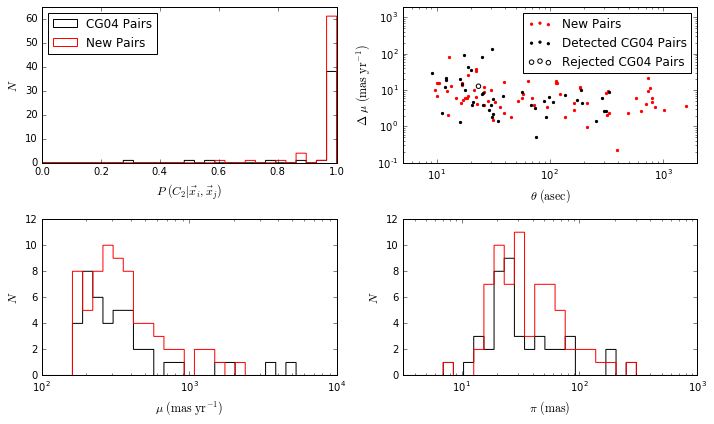

In [28]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

id1 = CG_pairs_hip_all['i_1']
id2 = CG_pairs_hip_all['i_2']


# P_posterior
bins = np.linspace(0.0, 1.0, 30)
ax[0,0].hist(CG_pairs_hip_all['P_posterior'], histtype='step', bins=bins, color='k', label='CG04 Pairs')
#ax[0,0].hist(p_ind['P_posterior'][idx_match], histtype='step', bins=bins, color='k', label='CG04 Pairs')
ax[0,0].hist(p_ind['P_posterior'][idx_new], histtype='step', bins=bins, color='r', label='New Pairs')
ax[0,0].set_ylim(0,65)
ax[0,0].set_yticks(np.linspace(0,60,7))
ax[0,0].set_xlabel(r'$P\ (C_2|\vec{x}_i, \vec{x}_j)$', fontsize=12)
ax[0,0].set_ylabel(r'$N$', fontsize=12)
ax[0,0].legend(loc=2)

# Theta vs. Delta Mu
delta_mu_ra = p_ind['mu_ra_1'] - p_ind['mu_ra_2']
delta_mu_dec = p_ind['mu_dec_1'] - p_ind['mu_dec_2']
delta_mu = np.sqrt(delta_mu_ra**2 + delta_mu_dec**2)
#ax[0,1].scatter(p_ind['theta'][idx_match]*3600.0, delta_mu[idx_match], color='k', label='CG04 Pairs')
ax[0,1].scatter(p_ind['theta'][idx_new]*3600.0, delta_mu[idx_new], color='r', label='New Pairs', s=5)
delta_mu_ra = t['mu_ra'][id1] - t['mu_ra'][id2]
delta_mu_dec = t['mu_dec'][id1] - t['mu_dec'][id2]
delta_mu = np.sqrt(delta_mu_ra**2 + delta_mu_dec**2)
ax[0,1].scatter(CG_pairs_hip_all['theta'][CG_pairs_hip_all['P_posterior']>0.5]*3600.0, \
                delta_mu[CG_pairs_hip_all['P_posterior']>0.5], color='k', label='Detected CG04 Pairs', s=5)
ax[0,1].scatter(CG_pairs_hip_all['theta'][CG_pairs_hip_all['P_posterior']<0.5]*3600.0, \
                delta_mu[CG_pairs_hip_all['P_posterior']<0.5], edgecolor='k', facecolor='none', label='Rejected CG04 Pairs')
ax[0,1].set_xlim(5.0, 2000.0)
ax[0,1].set_ylim(0.1, 2000.0)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].legend()
ax[0,1].set_xlabel(r'$\theta\ ({\rm asec})$', fontsize=12)
ax[0,1].set_ylabel(r'$\Delta\ \mu\ ({\rm mas\ yr}^{-1})$', fontsize=12)


# Mu
mu_1 = np.sqrt(p_ind['mu_ra_1']**2 + p_ind['mu_dec_1']**2)
mu_2 = np.sqrt(p_ind['mu_ra_2']**2 + p_ind['mu_dec_2']**2)
bins = 10**np.linspace(2.0, 4.0, 30)
ax[1,0].hist(mu_1[idx_match], histtype='step', bins=bins, color='k')
ax[1,0].hist(mu_1[idx_new], histtype='step', bins=bins, color='r')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel(r"$\mu\ ({\rm mas\ yr}^{-1})$", fontsize=12)
ax[1,0].set_ylim(0.0, 12.0)
ax[1,0].set_ylabel(r'$N$', fontsize=12)


# Parallax
bins = 10**np.linspace(0.5, 3.0, 30)
ax[1,1].hist(p_ind['plx_1'][idx_match], histtype='step', bins=bins, color='k')
ax[1,1].hist(p_ind['plx_1'][idx_new], histtype='step', bins=bins, color='r')
ax[1,1].set_xscale('log')
ax[1,1].set_xlim(10**0.5, 10**3.0)
ax[1,1].set_ylim(0.0, 12.0)
ax[1,1].set_xlabel(r"$\pi\ ({\rm mas})$", fontsize=12)
ax[1,1].set_ylabel(r'$N$', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/rNLTT_hipparchos_CG04_compare.pdf')
#plt.show()


### Let's look at the new pairs

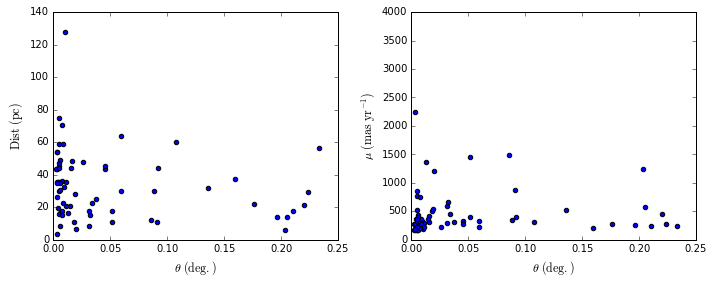

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].scatter(p_ind['theta'][idx_new], 1.0e3/p_ind['plx_1'][idx_new])

mu_1 = np.sqrt(p_ind['mu_ra_1']**2 + p_ind['mu_dec_1']**2)
ax[1].scatter(p_ind['theta'][idx_new], mu_1[idx_new])

ax[0].set_xlim(0, 0.25)
ax[0].set_ylim(0, 140)
ax[0].set_xlabel(r'$\theta\ ({\rm deg.})$', fontsize=12)
ax[0].set_ylabel(r'${\rm Dist}\ ({\rm pc})$', fontsize=12)

ax[1].set_xlim(0, 0.25)
ax[1].set_ylim(0, 4000)
ax[1].set_xlabel(r'$\theta\ ({\rm deg.})$', fontsize=12)
ax[1].set_ylabel(r'$\mu\ ({\rm mas\ yr}^{-1})$', fontsize=12)

plt.tight_layout()
plt.show()

In [30]:
id1 = p_ind['i_1'][idx_new]
id2 = p_ind['i_2'][idx_new]

N_no_B_photo = 0
for i in np.arange(len(id1)):
    if t['B'][id1[i]] == 0.0 or t['B'][id2[i]] == 0.0:
        N_no_B_photo = N_no_B_photo + 1

print N_no_B_photo, "of", len(id1), "new pairs lack B band photometry"

69 of 69 new pairs lack B band photometry


### Now, an RPM diagram of the new pairs

/Library/Python/2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in double_scalars


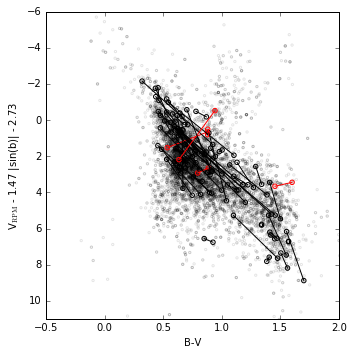

In [31]:
from astropy import units as u
from astropy.coordinates import SkyCoord

fig = plt.figure(figsize=(5,5))


for j in np.arange(100):
    
    # Any more than size=100 and we run into memory problems
    i = np.random.randint(len(t), size=100)
    id_test, id_hip = np.meshgrid(t['ID'][i], hip['HIP'])
    id3 = np.argmin(abs(id_test-id_hip), axis=0)

    BV = hip['B-V'][id3]
    ra_1, dec_1 = t['ra'][i], t['dec'][i]
    # Positions (Galactic)
    c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
    b_1 = c_1.galactic.b.radian

    mu_ra1, mu_dec1 = t['mu_ra'][i], t['mu_dec'][i]
    mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr

    eta_rpm_1 = t['V'][i] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73

    plt.scatter(BV[BV != 0.0], eta_rpm_1[BV != 0.0], marker='.', facecolors='none', edgecolors='k', alpha=0.1)



id1 = p_ind['i_1'][idx_new]
id2 = p_ind['i_2'][idx_new]

# Identified pairs
slope = np.zeros(len(id1))
length = np.zeros(len(id1))
for i in np.arange(len(id1)):
    id3 = np.where(t['ID'][id1[i]] == hip['HIP'])[0]
    id4 = np.where(t['ID'][id2[i]] == hip['HIP'])[0]
    
    BV_1 = hip['B-V'][id3][0]
    BV_2 = hip['B-V'][id4][0]
    BV_err_1 = hip['e_B-V'][id3][0]
    BV_err_2 = hip['e_B-V'][id4][0]
    
    ra_1, dec_1 = t['ra'][id1[i]], t['dec'][id1[i]]
    ra_2, dec_2 = t['ra'][id2[i]], t['dec'][id2[i]]
    # Positions (Galactic)
    c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
    c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
    b_1 = c_1.galactic.b.radian
    b_2 = c_2.galactic.b.radian

    mu_ra1, mu_dec1 = t['mu_ra'][id1[i]], t['mu_dec'][id1[i]]
    mu_ra2, mu_dec2 = t['mu_ra'][id2[i]], t['mu_dec'][id2[i]]
    mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
    mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
    
    eta_rpm_1 = t['V'][id1[i]] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
    eta_rpm_2 = t['V'][id2[i]] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
    
    if BV_1 == 0.0 or BV_2 == 0.0: continue
        
    slope[i] = (eta_rpm_2 - eta_rpm_1) / (BV_2 - BV_1)
    length[i] = np.sqrt((eta_rpm_2 - eta_rpm_1)**2 + (BV_2 - BV_1)**2)
        
    if np.arctan(slope[i]) < 0.0 and length[i] > 0.25:
#         print np.arctan(slope[i]) * 180./np.pi, length[i], t['V'][id1[i]], t['V'][id2[i]], t['NLTT'][id1[i]], t['NLTT'][id2[i]]
        plt.plot([BV_1, BV_2], [eta_rpm_1, eta_rpm_2], color='r')
        plt.scatter(BV_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='r')
        plt.scatter(BV_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='r')
    else:
        plt.plot([BV_1, BV_2], [eta_rpm_1, eta_rpm_2], color='k')
        plt.scatter(BV_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
        plt.scatter(BV_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')


# for i in np.arange(len(slope)):
#     if np.arctan(slope[i]) < 0.0 and length[i] > 0.25:
#         print np.arctan(slope[i]) * 180./np.pi, length[i], BV_err_1[i], BV_err_2[i]
    
plt.xlim(-0.5, 2.0)
plt.ylim(11.0, -6.0)

plt.xlabel('B-V')
plt.ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')

plt.tight_layout()
plt.savefig('../figures/rNLTT_hipparchos_CG04_rpm.pdf')
#plt.show()

### Now, let's look at the 8 rejected CG04 pairs

In [163]:
# Parallaxes

ids = np.where(CG_pairs_hip_all['P_posterior']<0.5)[0]
for i in ids:
    
    id1 = CG_pairs_hip_all['i_1'][i]
    id2 = CG_pairs_hip_all['i_2'][i]

    print "Probabilities:", CG_pairs_hip_all['P_posterior'][i], CG_pairs_hip_all['P_binary'][i], CG_pairs_hip_all['P_random'][i]
    print "Theta:", CG_pairs_hip_all["theta"][i]*3600.0
    print "Parallax:", CG_pairs_hip_all['plx_1'][i], CG_pairs_hip_all['plx_2'][i], t['plx_err'][id1], t['plx_err'][id2]
    print "Proper Motions:", CG_pairs_hip_all['mu_ra_1'][i], CG_pairs_hip_all['mu_ra_2'][i], \
        CG_pairs_hip_all['mu_dec_1'][i], CG_pairs_hip_all['mu_dec_2'][i]
    print ""
         


Probabilities: 0.0897550949723 9.15502394676e-11 4.93532081427e-10
Theta: 20.0028367678
Parallax: 21.11 -5.63 3.44 14.01
Proper Motions: 252.299994 275.900006 -3.59999994 24.2999997

Probabilities: 0.388118316543 3.04538593575e-10 2.14602265735e-10
Theta: 25.6851711513
Parallax: 48.29 31.43 6.07 2.52
Proper Motions: -9.70000029 -14.3999998 -174.099997 -167.500004

Probabilities: 0.0447270676248 7.1846513157e-12 7.15978935544e-11
Theta: 11.8767047718
Parallax: 7.75 -8.85 3.52 5.69
Proper Motions: -175.099999 -169.599995 -294.800013 -305.599988

Probabilities: 0.480973889537 5.76777494779e-10 3.85216113165e-10
Theta: 91.7884078032
Parallax: 12.17 17.15 2.91 1.58
Proper Motions: -93.0999964 -91.3000032 -175.400004 -175.600007

Probabilities: 0.275607155012 3.29510555887e-12 3.73110908954e-12
Theta: 23.3895471501
Parallax: 36.71 21.49 1.44 3.4
Proper Motions: -594.900012 -594.900012 296.299994 283.499986

Probabilities: 0.201169593537 4.03992616753e-10 8.44482659936e-10
Theta: 186.82662002